# PID Cartpole

I feel I can easily solve cart pole using a PID controller

What does sutton have to say? “Neuronlike Adaptive Elements That Can Solve Difficult Learning Control Problem”

- Critic neuron provides more informative feedback than reinforcement feedback can provide...

- Nueron is not simply a computer logic gate.

- 1983 - over 40 years ago... wtf...

- The enviroment is unable to provide the correct response (as in supervised learning) it must search for it, with trial-error, generate and test 



What would an embedding look like for the first layer?
n = 4
Lets say we embed the state into 100D space. 

If you want to discrtize it, the space grows factorily. n * n * n * n n^4 options

How to "run" policy. I also predict, but then I take the actual action.

I want to predict the state and also the reward. reward can just be part of the state. What if I have a loss function that also tries to maximise the reward, and minise the prediction loss. 

Curosity - take actions that lower the state prediction error. You can just close your eyes
Hunger - take actions that make you happy

In [2]:
import gymnasium as gym
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib qt
import torch

RENDER_HUMAN = False
if RENDER_HUMAN:
    env = gym.make('CartPole-v1', render_mode="human")
else:
    env = gym.make('CartPole-v1')

print("Action Space: ", env.action_space)
print("Obs Space: ", env.observation_space)


SEED = 0
torch.manual_seed(SEED)


Action Space:  Discrete(2)
Obs Space:  Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


In [125]:
# Initalize Agent Brain

HISTORY_LEN = 2

W = torch.normal(0,1,size=(4*HISTORY_LEN,4), requires_grad=True)

H = torch.zeros(size=(HISTORY_LEN,4))
# see https://stackoverflow.com/questions/51761806/is-it-possible-to-create-a-fifo-queue-with-pytorch
# Predict next obs, reward, terminal, and also take an action

L = torch.zeros(size=(100,))
print(L.shape)

torch.Size([100])


In [126]:
observation, info = env.reset(seed=SEED)

for _ in range(1000):

    if RENDER_HUMAN:
        env.render()    

    # forward pass - make prediction
    x = H.reshape(1, -1)
    y =  x @ W
    
    #world time step
    action = env.action_space.sample()  # agent policy that uses the observation and info
    # action = 0
    observation, reward, terminated, truncated, info = env.step(action)
    obs = torch.tensor(observation).reshape(1,4)
    #calculate prediction error
    loss = torch.abs(obs - y).mean()

    #backward pass
    W.grad = None
    loss.backward()
    W.data += -0.1 * W.grad

    # print(loss.item())
    # update history
    H = torch.cat((H[1:], obs))
    L = torch.cat((L[1:], torch.tensor([loss])))
    print("Avg loss: ", L.mean().item())


    # print(observation, reward, terminated, truncated, info)
    if terminated or truncated:
        observation, info = env.reset(seed=SEED)

env.close()

#History - Avg loss 
#1 - 0.146
#2 -  0.176
#3 - 0.18


Avg loss:  0.0012676708865910769
Avg loss:  0.004582026042044163
Avg loss:  0.009558402001857758
Avg loss:  0.013961567543447018
Avg loss:  0.01565340720117092
Avg loss:  0.020206261426210403
Avg loss:  0.02894269861280918
Avg loss:  0.041559986770153046
Avg loss:  0.055146511644124985
Avg loss:  0.07031533122062683
Avg loss:  0.08219824731349945
Avg loss:  0.09331308305263519
Avg loss:  0.10314968973398209
Avg loss:  0.11276262253522873
Avg loss:  0.12207777053117752
Avg loss:  0.12856337428092957
Avg loss:  0.1304091066122055
Avg loss:  0.13352170586585999
Avg loss:  0.13570189476013184
Avg loss:  0.13903558254241943
Avg loss:  0.14131282269954681
Avg loss:  0.1452627032995224
Avg loss:  0.15019451081752777
Avg loss:  0.15439286828041077
Avg loss:  0.16017284989356995
Avg loss:  0.1663268506526947
Avg loss:  0.17201568186283112
Avg loss:  0.17784371972084045
Avg loss:  0.18319034576416016
Avg loss:  0.18860505521297455
Avg loss:  0.1935642808675766
Avg loss:  0.199878990650177
Avg lo

In [129]:


observation, info = env.reset(seed=SEED)
actual_obs = [[] for _ in range(4)]
pred_obs = [[] for _ in range(4)]
random_pred_obs = [[] for _ in range(4)]
W_random = torch.normal(0,1,size=(8,4), requires_grad=True)

for _ in range(100):

    x = H.reshape(1, 8)
    y =  x @ W
    y_random =  x @ W_random

    action = env.action_space.sample()  # agent policy that uses the observation and info
    # action = 0
    observation, reward, terminated, truncated, info = env.step(action)
    obs = torch.tensor(observation).reshape(1,4)

    # Update actual and predicted observations
    for i in range(4):
        actual_obs[i].append(obs[0, i].item())
        pred_obs[i].append(y[0, i].item())
        random_pred_obs[i].append(y_random[0, i].item())

    H = torch.cat((H[1:], obs))

    if terminated or truncated:
        observation, info = env.reset(seed=SEED)

env.close()


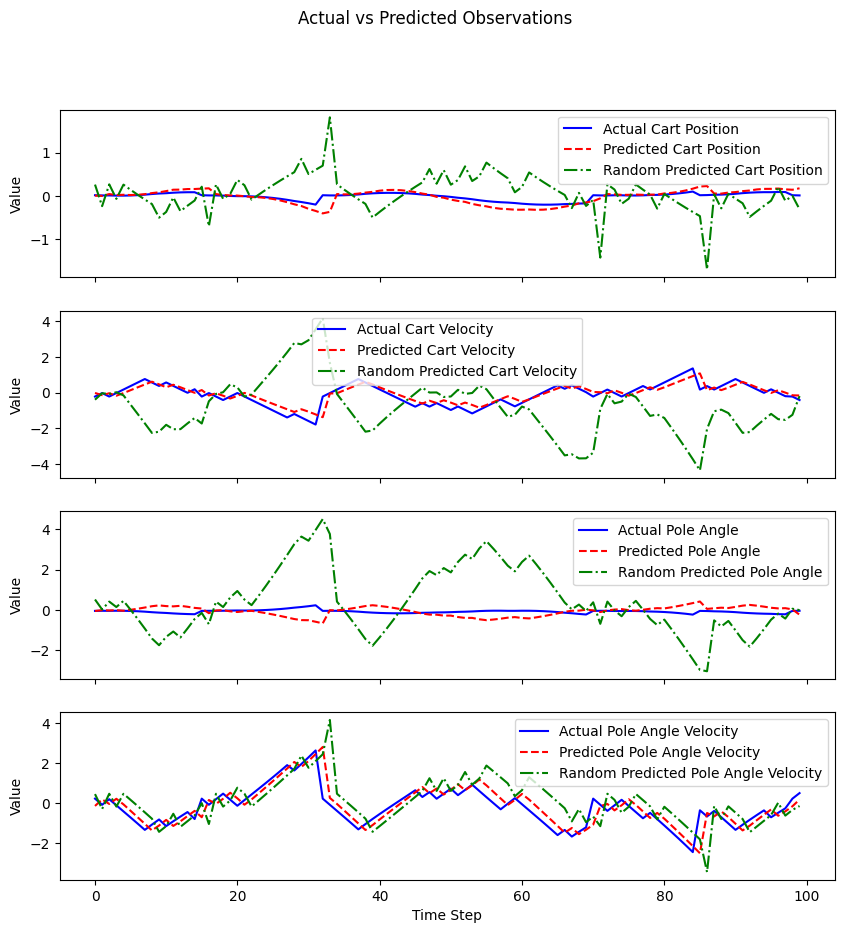

In [130]:
# Create subplots for each set of predicted and actual values
fig, axs = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

legend_labels = {
    1: 'Cart Position',
    2: 'Cart Velocity',
    3: 'Pole Angle',
    4: 'Pole Angle Velocity'
}

# Plot actual and predicted values for each set
for i in range(4):
    axs[i].plot(actual_obs[i], color='blue', linestyle='-', label=f'Actual {legend_labels[i+1]}')
    axs[i].plot(pred_obs[i], color='red', linestyle='--', label=f'Predicted {legend_labels[i+1]}')
    axs[i].plot(random_pred_obs[i], color='green', linestyle='-.', label=f'Random Predicted {legend_labels[i+1]}')
    axs[i].set_ylabel('Value')
    axs[i].legend()

# Add labels and title
axs[-1].set_xlabel('Time Step')
plt.suptitle('Actual vs Predicted Observations')

# Show the plot
plt.show()